# Pytorch Tutorial
---

From: [What is torch.nn really? by Jeremy Howard](https://pytorch.org/tutorials/beginner/nn_tutorial.html)

___

## 1. MNIST Data Setup

### Create Data Directory

In [1]:
from pathlib import Path
import requests

In [3]:
DATA_PATH = Path('../data')
PATH = DATA_PATH / 'mnist'

In [4]:
PATH.mkdir(parents=True, exist_ok=True)

In [5]:
URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

In [9]:
if not (PATH / FILENAME).exists():
    content = requests.get(URL+FILENAME).content
    (PATH / FILENAME).open('wb').write(content)

### Load Data

In [10]:
import pickle
import gzip

In [11]:
with gzip.open((PATH / FILENAME).as_posix(), 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

### Visualize Data

In [12]:
import matplotlib.pyplot as plt
import numpy as np

In [13]:
x_train.shape

(50000, 784)

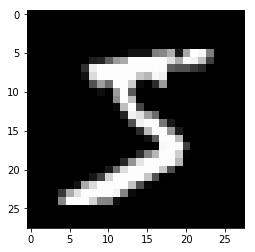

In [14]:
plt.imshow(x_train[0].reshape([28,28]), cmap='gray')

### Load as Torch Tensors

In [15]:
import torch

In [16]:
(x_train, y_train, x_valid, y_valid) = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

In [17]:
x_train.shape

torch.Size([50000, 784])

In [18]:
n,c = x_train.shape

In [19]:
x_train

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [20]:
y_train

tensor([5, 0, 4,  ..., 8, 4, 8])

In [21]:
y_train.max(), y_train.min()

(tensor(9), tensor(0))

## 2. Logistic Regression as Neural Network without torch.nn

### Weights and Bias

In [128]:
import math

In [129]:
# Xavier initialization 1/sqrt(n)
weights = torch.randn(784,10) / math.sqrt(784)
weights.requires_grad_()

tensor([[-0.0046,  0.0097, -0.0035,  ..., -0.0142,  0.0040,  0.0393],
        [-0.0079, -0.1071, -0.0048,  ..., -0.0335,  0.0068, -0.0041],
        [-0.0040,  0.0474, -0.0004,  ...,  0.0003,  0.0214,  0.0149],
        ...,
        [-0.0147, -0.0315, -0.0557,  ...,  0.0018, -0.0108, -0.0063],
        [-0.0290, -0.0433, -0.0159,  ..., -0.0366, -0.0537, -0.0076],
        [-0.0097,  0.0188,  0.0677,  ..., -0.1012,  0.0083, -0.0138]],
       requires_grad=True)

In [130]:
bias = torch.zeros(10, requires_grad=True)

### Build Model

In [131]:
xi = x_train[0:64]

In [132]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

In [133]:
def model(xb):
    return log_softmax(xb @ weights + bias)

In [134]:
bs=64
xb = x_train[0:bs]
yb = y_train[0:bs]

In [135]:
y_pred = model(xb)
print(y_pred.shape, yb.shape)

torch.Size([64, 10]) torch.Size([64])


In [136]:
y_pred[0]

tensor([-2.1781, -2.1968, -2.0577, -2.3931, -2.4483, -2.6294, -2.2951, -2.7303,
        -1.9937, -2.3455], grad_fn=<SelectBackward>)

### Loss Function

In [137]:
def nll(pred, target):
    return -pred[range(target.shape[0]), target].mean()

In [138]:
nll(y_pred, yb)

tensor(2.3335, grad_fn=<NegBackward>)

In [139]:
loss_fn = nll

### Accuracy

In [140]:
def accuracy(pred, target):
    pred = torch.argmax(pred, dim=1)
    return (pred == target).float().mean()

In [141]:
accuracy(y_pred, yb)

tensor(0.1094)

### Training Loop

In [142]:
epochs = 5
lr = 0.5
bs = 64

In [143]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
#         breakpoint()
        # grad a mini-batch
        start_i = i*bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        # forward pass
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        # update
        with torch.no_grad():
            weights -= lr*weights.grad
            bias -= lr*bias.grad
            weights.grad.zero_()
            bias.grad.zero_()

### Inference

In [144]:
accuracy(model(xb), yb)

tensor(1.)

In [145]:
loss_fn(model(xb), yb)

tensor(0.0622, grad_fn=<NegBackward>)

In [146]:
x = x_valid[0:10]
y = y_valid[0:10]

In [147]:
preds = model(x)

In [148]:
accuracy(preds,y)

tensor(0.9000)

In [149]:
loss_fn(preds,y)

tensor(0.2176, grad_fn=<NegBackward>)

## 3. Refactor using torch.nn.Functional

In [154]:
weights.mean(), weights.std()

(tensor(0.0002, grad_fn=<MeanBackward1>),
 tensor(0.1841, grad_fn=<StdBackward0>))

In [150]:
import torch.nn.functional as F

In [151]:
loss_fn = F.cross_entropy

In [152]:
def model(xb):
    return x @ weights + bias

In [155]:
loss_fn(preds,y)

tensor(0.2176, grad_fn=<NllLossBackward>)

In [156]:
accuracy(preds,y)

tensor(0.9000)

## 4. Refactor using torch.nn.Module

In [160]:
import torch.nn as nn

### Rebuild Model

In [219]:
class MNIST_Logistic(nn.Module):
    '''MNIST digit recognition using logistic regression'''
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(784,10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.randn(10))
    
    def forward(self, xb):
        return xb @ self.weight + self.bias
    
    def fit(self, x, y, lr, bs, epochs):
        losses = []
        for epoch in range(epochs):
            n = x.shape[0]
            for i in range((n-1)//bs + 1):
                start_i = i*bs
                end_i = start_i+bs
                xb = x[start_i:end_i]
                yb = y[start_i:end_i]
                pred = model(xb)
                loss = loss_fn(pred, yb)
                loss.backward()
                losses.append(loss.item())
                with torch.no_grad():
                    for p in self.parameters():
                        p -= lr*p.grad
                        p.grad.zero_()
        return losses

In [220]:
model = MNIST_Logistic()

In [221]:
accuracy(model(xb), yb), loss_fn(model(xb), yb)

(tensor(0.2500), tensor(2.6002, grad_fn=<NllLossBackward>))

In [222]:
losses = model.fit(x=x_train, y=y_train, lr=0.5, bs=64, epochs=5)

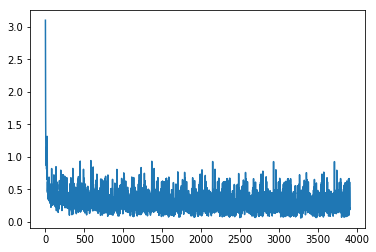

In [224]:
plt.plot(losses)

In [226]:
accuracy(model(xb), yb)

tensor(1.)

In [227]:
loss_fn(model(xb), yb)

tensor(0.0598, grad_fn=<NllLossBackward>)

## 5. Refactor using Pytorch optim

In [228]:
import torch.optim as optim

In [229]:
class MNIST_Logistic(nn.Module):
    '''MNIST digit recognition using logistic regression'''
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(784,10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.randn(10))
    
    def forward(self, xb):
        return xb @ self.weight + self.bias
    
    def fit(self, x, y, lr, bs, epochs):
        opt = optim.SGD(self.parameters(), lr=lr)
        losses = []
        for epoch in range(epochs):
            n = x.shape[0]
            runs = (n-1)//bs + 1
            for i in range(runs):
                start_i = i*bs
                end_i = start_i+bs
                xb = x[start_i:end_i]
                yb = y[start_i:end_i]
                pred = model(xb)
                loss = loss_fn(pred, yb)
                loss.backward()
                losses.append(loss.item())
                opt.step()
                opt.zero_grad()
        return losses

In [230]:
model = MNIST_Logistic()

In [231]:
accuracy(model(xb), yb), loss_fn(model(xb), yb)

(tensor(0.), tensor(3.7941, grad_fn=<NllLossBackward>))

In [232]:
losses = model.fit(x=x_train, y=y_train, lr=0.5, bs=64, epochs=5)

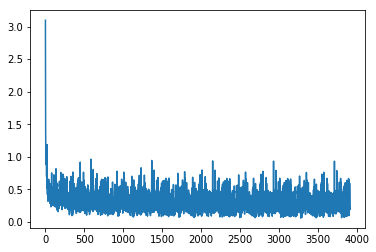

In [233]:
plt.plot(losses)

In [234]:
accuracy(model(xb), yb)

tensor(1.)

In [235]:
loss_fn(model(xb), yb)

tensor(0.0632, grad_fn=<NllLossBackward>)

## 6. Refactor using Pytorch's TensorDataset

In [236]:
from torch.utils.data import TensorDataset

In [237]:
train_ds = TensorDataset(x_train,y_train)
valid_ds = TensorDataset(x_valid,y_valid)

In [252]:
class MNIST_Logistic(nn.Module):
    '''MNIST digit recognition using logistic regression'''
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(784,10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.randn(10))
    
    def forward(self, xb):
        return xb @ self.weight + self.bias
    
    def fit(self, ds, lr, bs, epochs):
        opt = optim.SGD(self.parameters(), lr=lr)
        losses = []
        for epoch in range(epochs):
            n = len(ds)
            runs = (n-1)//bs + 1
            for i in range(runs):                
                xb, yb = train_ds[i*bs:i*bs+bs]
                pred = model(xb)
                loss = loss_fn(pred, yb)
                loss.backward()
                losses.append(loss.item())
                opt.step()
                opt.zero_grad()
        return losses

In [253]:
model = MNIST_Logistic()

In [254]:
accuracy(model(xb), yb), loss_fn(model(xb), yb)

(tensor(0.2500), tensor(2.4059, grad_fn=<NllLossBackward>))

In [255]:
losses = model.fit(ds=train_ds, lr=0.5, bs=64, epochs=5)

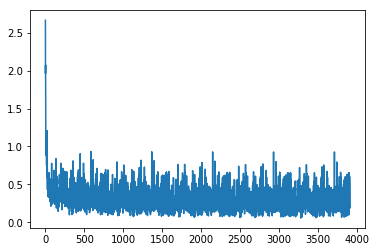

In [256]:
plt.plot(losses)

In [257]:
accuracy(model(xb), yb)

tensor(1.)

In [258]:
loss_fn(model(xb), yb)

tensor(0.0618, grad_fn=<NllLossBackward>)

## 7. Refactor using Pytorch Dataloader

In [259]:
from torch.utils.data import DataLoader

In [261]:
bs=64

In [265]:
train_dl = DataLoader(train_ds, batch_size=bs)
valid_dl = DataLoader(valid_ds, batch_size=bs)

In [282]:
class MNIST_Logistic(nn.Module):
    '''MNIST digit recognition using logistic regression'''
    
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn([784,10]) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
    
    def forward(self, xb):
        return xb @ self.weight + self.bias

    def fit(self, dl, lr, epochs=5):
        opt = optim.SGD(self.parameters(), lr=lr)
        losses = []
        for epoch in range(epochs):
            for xb, yb in dl:
                preds = model(xb)
                loss = loss_fn(preds, yb)
                losses.append(loss.item())
                loss.backward()
                opt.step()
                opt.zero_grad()
        return losses

In [283]:
model = MNIST_Logistic()

In [284]:
for xb, yb in valid_dl:
    print(xb.shape)
    print(yb.shape)
    break

torch.Size([64, 784])
torch.Size([64])


In [285]:
loss_fn(model(xb), yb)

tensor(2.4151, grad_fn=<NllLossBackward>)

In [286]:
accuracy(model(xb), yb)

tensor(0.0625)

In [287]:
losses = model.fit(train_dl, lr=0.5)

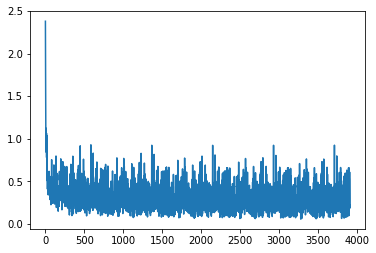

In [288]:
plt.plot(losses)

In [289]:
loss_fn(model(xb), yb)

tensor(0.2638, grad_fn=<NllLossBackward>)

In [290]:
accuracy(model(xb), yb)

tensor(0.9375)

## 8. Add validation

In [413]:
class MNIST_Logistic(nn.Module):
    '''MNIST digit recognition using logistic regression'''
    
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn([784,10]) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
    
    def forward(self, xb):
        return xb @ self.weight + self.bias

In [414]:
def get_model(lr=0.5):
    model = MNIST_Logistic()
    return model, optim.SGD(model.parameters(), lr)

In [415]:
def get_data(x_train, y_train, x_valid, y_valid, bs):
    train_dl = DataLoader(TensorDataset(x_train, y_train), bs, shuffle=True)
    valid_dl = DataLoader(TensorDataset(x_valid, y_valid), bs*2, shuffle=False)
    return train_dl, valid_dl

In [416]:
def loss_batch(model, xb, yb, loss_fn, opt=None):
    loss = loss_fn(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    return loss.item(), len(xb)

In [417]:
def fit(model, train_dl, valid_dl, opt, loss_fn, epochs=5):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            _,_ = loss_batch(model, xb, yb, loss_fn, opt)
        
            
        model.eval()
        with torch.no_grad():
            losses, nums = zip(*[loss_batch(model, xb, yb, loss_fn) 
                                 for xb, yb in valid_dl])
        print(f"EPOCH:{epoch} LOSS:{np.sum(np.multiply(losses,nums))/sum(nums)}")

In [418]:
train_dl, valid_dl = get_data(x_train, y_train, x_valid, y_valid, bs=64)

In [426]:
model, opt = get_model()

In [427]:
fit(model, train_dl, valid_dl, opt, loss_fn=F.cross_entropy)

EPOCH:0 LOSS:0.3953435242652893
EPOCH:1 LOSS:0.3283374345779419
EPOCH:2 LOSS:0.3375787838935852
EPOCH:3 LOSS:0.2807070924758911
EPOCH:4 LOSS:0.2732050292015076


In [428]:
loss_fn(model(xb), yb)

tensor(0.3094, grad_fn=<NllLossBackward>)

In [429]:
accuracy(model(xb), yb)

tensor(0.9219)

## 9. Building Convolutional Network

In [595]:
class MNIST_CNN(nn.Module):
    '''MNIST digit recognition using convolutional layers'''
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
    
    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        out = F.avg_pool2d(xb, 4)
        return out.view(-1, 10)

In [596]:
model=MNIST_CNN()
opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [597]:
fit(model, train_dl, valid_dl, opt, loss_fn=F.cross_entropy)

EPOCH:0 LOSS:0.5639297435283661
EPOCH:1 LOSS:0.25318977360725403
EPOCH:2 LOSS:0.18602420806884765
EPOCH:3 LOSS:0.1980684537410736
EPOCH:4 LOSS:0.16438018531799317


In [598]:
for xb, yb in valid_dl:
    break

In [599]:
loss_fn(model(xb), yb)

tensor(0.1264, grad_fn=<NllLossBackward>)

In [600]:
accuracy(model(xb), yb)

tensor(0.9688)

## 10. Using Pytorch Sequential

In [608]:
def preprocess(x):
    return x.view(-1,1,28,28)

In [609]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)

In [610]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.AvgPool2d(kernel_size=4),
    Lambda(lambda x: x.view(-1,10))
)

In [611]:
opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [616]:
fit(model, train_dl, valid_dl, opt, loss_fn=F.cross_entropy)

EPOCH:0 LOSS:0.21935994367599487
EPOCH:1 LOSS:0.21811385908126832
EPOCH:2 LOSS:0.19248123455047608
EPOCH:3 LOSS:0.19255559163093566
EPOCH:4 LOSS:0.1938586718082428


In [618]:
for xb, yb in valid_dl:
    break

In [619]:
loss_fn(model(xb), yb)

tensor(0.1779, grad_fn=<NllLossBackward>)

In [620]:
accuracy(model(xb), yb)

tensor(0.9453)

## 11. Refactor Dataloader

In [645]:
def preprocess(x, y):
    return (x.view(-1, 1, 28, 28), y)

In [659]:
class WrappedDataLoader:
    
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        batches = iter(self.dl)
        for xb,yb in batches:
            yield (self.func(xb,yb))

In [660]:
def get_data(x_train, y_train, x_valid, y_valid, bs):
    train_dl = DataLoader(TensorDataset(x_train, y_train), bs, shuffle=True)
    valid_dl = DataLoader(TensorDataset(x_valid, y_valid), bs*2, shuffle=False)
    train_dl = WrappedDataLoader(train_dl, preprocess)
    valid_dl = WrappedDataLoader(valid_dl, preprocess)
    return train_dl, valid_dl

In [668]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(-1,10))
)

In [669]:
train_dl, valid_dl = get_data(x_train, y_train, x_valid, y_valid, bs)

In [671]:
opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

In [672]:
fit(model, train_dl, valid_dl, opt, loss_fn=F.cross_entropy)

EPOCH:0 LOSS:0.504665928888321
EPOCH:1 LOSS:0.3205092090368271
EPOCH:2 LOSS:0.3137759463071823
EPOCH:3 LOSS:0.25552761492729187
EPOCH:4 LOSS:0.26341195023059844


In [673]:
for xb, yb in valid_dl:
    break

In [674]:
loss_fn(model(xb), yb)

tensor(0.2368, grad_fn=<NllLossBackward>)

In [675]:
accuracy(model(xb), yb)

tensor(0.9297)

# Conclusion
---

__torch.nn__
* **nn.Module**:
        * makes it into a callable as a function
        * contains state like layer weights
* **nn.Parameters**:
        * tells the Module that these weights needs to be updated during backprop
        * only Parameters with requires_grad=True are updated
* **nn.functional**:
        * contains loss functions, activation functions, etc
        * contains non-stateful versions of convolution and linear layers

**torch.optim**:
    * coatains optimizers such as SGD
    * step() to update weights with computed grads
    * zero_grad() to zero out grads after each step 

**Dataset**:
    * wrapper around tensor objects with __len__ and __getitem__

**DataLoader**:
    * Takes any Dataset and iterates over it in batches
    * Implemented with a for loop over an iter object yielding in its body